In [0]:
import pandas as pd
import os

from PIL import Image
import matplotlib.pyplot as plot
import matplotlib.patches as patches
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

from bs4 import BeautifulSoup as bs

import math
import tensorflow.keras.backend as K

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
class Config:
    
    def __init__(self):
        
        self.FM_STRIDE_X = 32
        self.FM_STRIDE_Y = 32
                
        self.IMG_WIDTH = 224
        self.IMG_HEIGHT = 224
    
        self.OUTPUT_WIDTH = self.IMG_WIDTH // self.FM_STRIDE_X
        self.OUTPUT_HEIGHT = self.IMG_HEIGHT // self.FM_STRIDE_Y
        
    
        self.MIN_IOU = 0.1
        self.MAX_IOU = 0.6
        
        self.BATCH_SIZE = 64
        self.EPOCHS = 100
        
        self.CLASS_LAMBDA = 0.5
        self.OBJECT_LAMBDA = 0.5
        self.COORD_LAMBDA = 0.5
        
        self.ANCHORS = [
           [1.19, 1.99],     
           [2.79, 4.60],     
           [4.54, 8.93],   
           [8.06, 5.29],
           [10.33, 10.65]
        ]
        
        self.CLASSES = {
                'person':0, 
                'bird': 1,
                'cat':2,
                'cow':3,
                'dog':4,
                'horse':5, 
                'sheep':6,
                'aeroplane':7,
                'bicycle':8,
                'boat':9,
                'bus':10,
                'car':11,
                'motorbike':12,
                'train':13,
                'bottle':14,
                'chair':15,
                'diningtable':16,
                'pottedplant':17,
                'sofa':18,
                'tvmonitor':19
            }
        

C = Config()

In [0]:
def calculate_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou


Downloading data

In [0]:
if os.path.isfile('VOCtrainval_11-May-2012.tar') == False:
    !wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
    !tar -xf VOCtrainval_11-May-2012.tar

In [0]:
def get_bboxes(image_filename): 
    
    file = open('VOCdevkit/VOC2012/Annotations/' + image_filename + '.xml').read()
    annot = bs(file)

    bboxes = []
    
    for object in annot.findAll('object'):
        try:
            class_name = object.find('name').text
            xmin = int(float(object.xmin.text))
            xmax = int(float(object.xmax.text))
            ymin = int(float(object.ymin.text))
            ymax = int(float(object.ymax.text))

            bboxes.append([xmin,ymin,xmax,ymax,class_name])
        except:
            print('Broken ', image_filename)
    return bboxes

    
   

In [0]:
def resize_image(C, image_name):

    size = C.IMG_WIDTH, C.IMG_HEIGHT
    
    im = Image.open('VOCdevkit/VOC2012/JPEGImages/' + image_name + '.jpg')
    
    scale = C.IMG_WIDTH / max(im.size)
    
    im.thumbnail(size, Image.ANTIALIAS)
    
    x_offset = (size[0] - im.size[0])//2
    y_offset = (size[1] - im.size[1])//2
    
         
    final = Image.new(mode='RGB',size=size,color=(0,0,0))
    final.paste(im, (x_offset, y_offset))
                
    bboxes = get_bboxes(image_name)
    scaled_bboxes = []
    
    for bbox in bboxes:
        
        xmin = int(bbox[0] * scale) + x_offset
        ymin = int(bbox[1] * scale) + y_offset
        xmax = int(bbox[2] * scale) + x_offset
        ymax = int(bbox[3] * scale) + y_offset

        scaled_bbox = [xmin,ymin,xmax,ymax, bbox[4]]
        scaled_bboxes.append(scaled_bbox)
                
    return np.array(final), scaled_bboxes
    
   

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

def flip_horizontally(C, img, scaled_bboxes):

    flipped_img = np.fliplr(img)
         
    for i, bbox in enumerate(scaled_bboxes):
        
        x1 = C.IMG_WIDTH - bbox[0]
        x2 = C.IMG_WIDTH - bbox[2]
        
        bbox[0] = min(x1,x2)
        bbox[2] = max(x1,x2)
        
        scaled_bboxes[i] = bbox
        
    return flipped_img, scaled_bboxes

def shift_intensity(img):
   
    params = {
        'channel_shift_intensity':10
    }
    new_img = IDG().apply_transform(img,params)
    
    return new_img

def shift_brightness(img):
    
    params = {
        'brightness':0.01, 
    }
    new_img = IDG().apply_transform(img,params)
    
    return new_img

In [0]:
def get_img_bboxes(C, image_name):
    
    need_shift_brightness = np.random.randint(2,size=1)[0]
    need_shift_incensity = np.random.randint(2,size=1)[0]
    need_flip = np.random.randint(2,size=1)[0]
    
    img, bboxes = resize_image(C, image_name)
   
    if need_flip:
        img, bboxes = flip_horizontally(C, img, bboxes)
    if need_shift_incensity:
        img = shift_intensity(img)
    if need_shift_brightness:
        img = shift_brightness(img)
        
    return img, bboxes
    

In [0]:
def get_ground_truth_data(C, bboxes):
    
    #bboxes is an array of arrays [[xmin,ymin,xmax,ymax,class_name]]
    
    fm_stride_x =  C.FM_STRIDE_X
    fm_stride_y = C.FM_STRIDE_Y 
    
    output_width = C.OUTPUT_WIDTH 
    output_height = C.OUTPUT_HEIGHT
    
    img_width = C.IMG_WIDTH
    img_height = C.IMG_HEIGHT
    
    classes = C.CLASSES
    anchors = C.ANCHORS
    
    cells_full_data = np.zeros((output_width, output_width, 125), dtype='float32') 
    
    
    for bbox_index, bbox in enumerate(bboxes):
        
        bbox_center_x = (bbox[2] + bbox[0]) // 2
        bbox_center_y = (bbox[3] + bbox[1]) // 2
        bbox_width = bbox[2] - bbox[0]
        bbox_height = bbox[3] - bbox[1]
            
        x_fm = bbox_center_x // fm_stride_x
        y_fm = bbox_center_y // fm_stride_y
        
        xmin = x_fm*fm_stride_x
        xmax = (x_fm + 1)*fm_stride_x
            
        ymin = y_fm*fm_stride_y
        ymax = (y_fm + 1)*fm_stride_y 
            
        cell_coord = [xmin, ymin, xmax, ymax]    
            
        cell_center_x = (xmin + xmax) / 2
        cell_center_y = (ymin + ymax) / 2
            
        max_iou = 0
        best_anchor_index = 0
        
        for anchor_index, anchor_size in enumerate(anchors):
                        
            anchor_width = anchor_size[0] * fm_stride_x
            anchor_height = anchor_size[1] * fm_stride_y
            
            anchor_xmin = cell_center_x - anchor_width // 2
            anchor_xmax = cell_center_x + anchor_width // 2
            
            anchor_ymin = cell_center_y - anchor_height // 2
            anchor_ymax = cell_center_y + anchor_height // 2
                        
            anchor_center_x = (anchor_xmin + anchor_xmax) / 2
            anchor_center_y = (anchor_ymin + anchor_ymax) / 2
                
            anchor_coord = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]

            iou = calculate_iou(anchor_coord, bbox[:4])

            if iou > max_iou:

                max_iou = iou
                best_anchor_index = anchor_index
        
        scale = 8
        
        x = (bbox_center_x - xmin) / fm_stride_x
        if x == 0: x = 0.01

        delta_x = math.log(x/(1-x)) / scale
        
        y = (bbox_center_y - ymin) / fm_stride_y
        if y == 0: y = 0.01
        delta_y = math.log(y/(1-y))  / scale
        
        best_anchor = anchors[best_anchor_index]
    
        delta_width = math.log(bbox_width / (best_anchor[0] * fm_stride_x)) 
        delta_height = math.log(bbox_height / (best_anchor[1] * fm_stride_y))
                
        cells_full_data[x_fm, y_fm, best_anchor_index * 25: best_anchor_index * 25 + 5] = [delta_x, delta_y, delta_width, delta_height, 1]
            
#             creating hot encoded class
        hot_encoded_class = np.zeros((20), dtype='float32')
            
        class_name = bbox[4]
        class_index = classes[class_name]
            
        hot_encoded_class[class_index] = 1
                
        cells_full_data[x_fm, y_fm, best_anchor_index * 25 + 5:best_anchor_index * 25 + 5 + 20] = hot_encoded_class
                        
    return cells_full_data

In [0]:
def show(img, bboxes, data):
    
    fig,ax = plot.subplots(1)
    ax.imshow(img)
    
    for bbox in bboxes:
        
        x = bbox[0]
        y = bbox[1]
        
        width = bbox[2] - x
        height = bbox[3] - y
        
        
        bbox_center_x = (bbox[2] + bbox[0]) // 2
        bbox_center_y = (bbox[3] + bbox[1]) // 2
        bbox_width = bbox[2] - bbox[0]
        bbox_height = bbox[3] - bbox[1]
        
        print(bbox_center_x)
        print(bbox_center_y)
        print(bbox_width)
        print(bbox_height)
        
        rect = patches.Rectangle((x,y), width, height, linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    anchors = C.ANCHORS
    
    for x in range(7):
        
        for y in range(7):
            
            detectors = data[x,y,:]
    
            for anchor_index, object in enumerate(detectors[4::25]):
 
                if object == 1:
                    
                    width = anchors[anchor_index][0] * 32
                    height = anchors[anchor_index][1] * 32
                    
                    x_c = x * 32 + 16 - width // 2
                    y_c = y * 32 + 16 - height // 2
                                        
                    rect = patches.Rectangle((x_c,y_c), width, height, linewidth=1,edgecolor='g',facecolor='none')
                    ax.add_patch(rect)
                    
                    reshaped = detectors.reshape(5,25)
                    detector = reshaped[anchor_index]
                    
                    print(detector)
                    
                    delta_x = detector[0]
                    delta_y = detector[1]
                    
                    delta_w = detector[2]
                    delta_h = detector[3]

    
                    print("x = ", x * 32 + (1 / (1 + math.exp(-delta_x * 8))) * 32.0)
                    print("y = ", y * 32 + (1 / (1 + math.exp(-delta_y * 8 ))) * 32.0)

                    print('width = ', anchors[anchor_index][0] * math.exp(delta_w) * 32)
                    print('height = ', anchors[anchor_index][1] * math.exp(delta_h) * 32)


                    

2012_001164
143
131
105
129
[-0.01564539 -0.28358543  0.16218285 -0.13197981  1.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
x =  143.0000000401725
y =  131.00000029304223
width =  105.00000011563905
height =  128.99999919010924


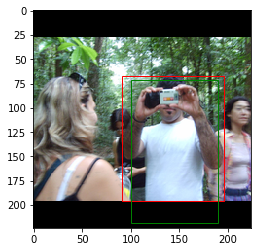

In [0]:
files = os.listdir('VOCdevkit/VOC2012/JPEGImages')

for file in files[9001:9002]:
    
    filename, file_extension = os.path.splitext(file)
    print(filename)
    img, scaled_bboxes = get_img_bboxes(C, filename)
    cell_data = get_ground_truth_data(C, scaled_bboxes)
    
    show(img, scaled_bboxes, cell_data)
  


In [0]:
def image_data_generator(images, batch_size):
    
    while True:
        
        random_files = np.random.choice(images, batch_size)
        
        input_batch = np.empty((batch_size, C.IMG_WIDTH, C.IMG_HEIGHT, 3), dtype='int32')
        output_batch = np.empty((batch_size, C.OUTPUT_WIDTH, C.OUTPUT_HEIGHT, 125))
        
        
        for file_index, file in enumerate(random_files):
            
            filename, file_extension = os.path.splitext(file)
    
            img, scaled_bboxes = get_img_bboxes(C,filename)  
            gt_data = get_ground_truth_data(C, scaled_bboxes)

            input_batch[file_index] = img
            output_batch[file_index] = gt_data

        
        yield (input_batch, output_batch)
            

In [0]:
def rpn_loss_reg(scale,class_lambda, object_lambda, coord_lambda):
               
    def rpn_loss_regr_fixed_num(y_trues, y_preds):
        
        loss = 0
        
        for s, y_pred, y_true in zip(scales, y_preds, y_trues):

            shape = K.shape(y_true)

            true_reshaped = K.reshape(y_true, (C.BATCH_SIZE, s, s, 3, 25))
            pred_reshaped = K.reshape(y_pred, (C.BATCH_SIZE, s, s, 3, 25))

            mask = true_reshaped[:,:,:,:,4]

            class_loss =  class_lambda * K.binary_crossentropy(true_reshaped[:,:,:,:,5:],K.sigmoid(pred_reshaped[:,:,:,:,5:]), from_logits=True))

            object_square = K.square(mask - K.sigmoid(pred_reshaped[:,:,:,:,4]))
            object_loss = object_lambda * K.sum(object_square)

#             no_object_square = K.square(0 - K.sigmoid(pred_reshaped[:,:,:,:,4]))
#             no_object_loss = object_lambda * K.sum(no_object_square)

            coord_square = K.square(true_reshaped[:,:,:,:,:4] - pred_reshaped[:,:,:,:,:4])
            coord_loss = coord_lambda * K.sum(coord_square)

            loss += (class_loss + object_loss + coord_loss)
        
        return loss
        
    return rpn_loss_regr_fixed_num


In [0]:
a = np.random.rand(1,2,2,2,2)
b = np.random.rand(1,2,2,2,2)
    
print('a ', a)
print('b ', b)
# print('aaaaa', a[:,:,:,:,1:])
    
mask = tf.convert_to_tensor(a)[:,:,:,:,0]
r = tf.convert_to_tensor(b)[:,:,:,:,0]
reshaped_b = K.reshape(b, (1,2,2,4))

# tile = K.repeat_elements(pred,2,3)
# mask_ = K.reshape(tile, (1,2,2,2,2))

reverse_mask = 1 - mask

with tf.Session() as sess:
#     print('reshaped b = ', sess.run(reshaped_b))
#     print('mask = ', sess.run(mask_))
#     print('masked ', sess.run(mask_ * b))
#     print('softmax(b) = ', sess.run(K.softmax(b)))
    print(sess.run(K.sigmoid(r)))    
    
#     print('pred = ', sess.run(pred))

In [0]:
# custom metrics 
def coord_loss(y_true, y_pred):
  
    true_reshaped = K.reshape(y_true, (64, 7, 7, 5, 25))
    pred_reshaped = K.reshape(y_pred, (64, 7, 7, 5, 25))
    
    pred = K.cast(K.greater(mask, 0.5), 'float32') 
    
    return K.sum(K.square(true_reshaped[:,:,:,:,:4] - pred_reshaped[:,:,:,:,:4]))

def class_loss(y_true, y_pred):
   
    true_reshaped = K.reshape(y_true, (64, 7, 7, 5, 25))
    pred_reshaped = K.reshape(y_pred, (64, 7, 7, 5, 25))
    
    return K.categorical_crossentropy(true_reshaped[:,:,:,:,5:],K.softmax(pred_reshaped[:,:,:,:,5:]))


def objectness_loss(y_true, y_pred):
   
    true_reshaped = K.reshape(y_true, (64, 7, 7, 5, 25))
    pred_reshaped = K.reshape(y_pred, (64, 7, 7, 5, 25))
    
    object_square = K.square(1 - K.sigmoid(pred_reshaped[:,:,:,:,4]))
    
    return K.sum(object_square)


Creating the model

In [0]:
base_model = MobileNet(input_shape=(224,224,3),include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# x = Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros')(base_model.output)
# x = Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros')(x)
# x = Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros')(x)


# x = Conv2D(32,(3,3), padding='same', activation='relu')(base_model.output)
# x = Conv2D(64,(1,1), padding='same', activation='relu')(x)
# x = Conv2D(128,(3,3), padding='same', activation='relu')(x)

# x = Conv2D(256,(3,3), padding='same', activation='relu')(x)
# x = Conv2D(128,(1,1), padding='same', activation='relu')(x)
# x = Conv2D(256,(3,3), padding='same', activation='relu')(x)


# x = Conv2D(128,(3,3), padding='same', activation='relu')(x)
# x = Conv2D(256,(3,3), padding='same', activation='relu')(x)

pred = Conv2D(125,(1,1), padding='same')(base_model.output)

model = Model(inputs=base_model.input, outputs=pred)

In [0]:
# print(len(model.layers))
# print(model.summary())
optimizer = optimizers.SGD(lr=0.0000001, decay=0.00005, momentum=0.9)
# optimizer = 'adam'

model.compile(loss=rpn_loss_reg(C), optimizer=optimizer, metrics=[coord_loss, class_loss, objectness_loss])

In [0]:
from tensorflow.keras import callbacks

def scheduler(epoch):
    
    initial_lr = 0.001
    
    if epoch > 40:
        return initial_lr / 10 / 10
    elif epoch > 20:
        return initial_lr / 10 

    
    return initial_lr
    
lr_scheduler = callbacks.LearningRateScheduler(scheduler, verbose=1)

In [0]:
files = os.listdir('VOCdevkit/VOC2012/JPEGImages')
n = len(files)

steps_per_epoch = n // C.BATCH_SIZE

model.fit_generator(image_data_generator(files, C.BATCH_SIZE), steps_per_epoch=steps_per_epoch, epochs = C.EPOCHS, callbacks=[])